## 0. Enunciado

En este ejercicio se propone un conjunto de datos recopilado a partir de un escenario en el que se han realizado un conjunto de ataques sobre una infraestructura de red.  

El objetivo del ejercicio es construir un modelo capaz de identificar este tipo de ataques en una infraestructura de red real. Para completar el ejercicio satisfactoriamente el alumno debe:
* Construir un modelo predictivo utilizando un **algoritmo de clasficación** basado en apredizaje supervisado (regresión logistica, árbol de decisión, random forests)
* Construir un modelo predictivo utilizando un **algoritmo de detección de anomalías** (distribución gaussiana, isolation forest)
* **Completar las secciones** que se presentan a lo largo de este jupyter notebook

### Dataset

#### Abstract
NSL-KDD is a data set suggested to solve some of the inherent problems of the KDD'99 data set which are mentioned in [1]. Although, this new version of the KDD data set still suffers from some of the problems discussed by McHugh [2] and may not be a perfect representative of existing real networks, because of the lack of public data sets for network-based IDSs, we believe it still can be applied as an effective benchmark data set to help researchers compare different intrusion detection methods. Furthermore, the number of records in the NSL-KDD train and test sets are reasonable. This advantage makes it affordable to run the experiments on the complete set without the need to randomly select a small portion. Consequently, evaluation results of different research work will be consistent and comparable.

#### Data Files
* KDDTrain+.ARFF: The full NSL-KDD train set with binary labels in ARFF format
* **KDDTrain+.TXT**: The full NSL-KDD train set including attack-type labels and difficulty level in CSV format
* KDDTrain+_20Percent.ARFF:	A 20% subset of the KDDTrain+.arff file
* KDDTrain+_20Percent.TXT:	A 20% subset of the KDDTrain+.txt file
* KDDTest+.ARFF:	The full NSL-KDD test set with binary labels in ARFF format
* **KDDTest+.TXT**:	The full NSL-KDD test set including attack-type labels and difficulty level in CSV format
* KDDTest-21.ARFF:	A subset of the KDDTest+.arff file which does not include records with difficulty level of 21 out of 21
* KDDTest-21.TXT:	A subset of the KDDTest+.txt file which does not include records with difficulty level of 21 out of 21

## 1. Lectura del conjunto de datos

Carga el conjunto de datos utilizando alguno de los frameworks que se ha visto durante la realización de los ejercicios del curso:
* Almacena los datos en las variables adecuadas
* Separa el conjunto de datos en las características de entrada y el valor de salida (etiqueta)
* **Separa el conjunto de datos en los subconjuntos de entramiento, validación y pruebas**

**NOTA**: URL del dataset de entrenamiento: http://www.almhuette-raith.at/apache-log/access.log

Vamos a definir un par de funciones para ayudar a la carga de los datos:

**parse_str**: 

**parse_datetime**:

**NOTA**: El código de estas funciones se encuentra en https://mmas.github.io/read-apache-access-log-pandas

In [37]:
from datetime import datetime
import pytz

# Returns the string delimited by two characters.
# Example: parse_str('[my string]') => 'my string'
def parse_str(x):
    return x[1:-1]

# Parses datetime with timezone formatted as: [day/month/year:hour:minute:second zone]
# Example: parse_datetime('13/Nov/2015:11:45:42 +0000') 
#    => datetime.datetime(2015, 11, 3, 11, 45, 4, tzinfo=<UTC>)

def parse_datetime(x):
    try: 
        dt = datetime.strptime(x[1:-7], '%d/%b/%Y:%H:%M:%S')
        dt_tz = int(x[-6:-3])*60+int(x[-3:-1])
        return dt.replace(tzinfo=pytz.FixedOffset(dt_tz))
    except:
        return "Error loading data"

In [38]:
import re
import pandas as pd

X_test = pd.read_csv(
    'datasets/access.log',
    sep=r'\s(?=(?:[^"]*"[^"]*")*[^"]*$)(?![^\[]*\])',
    engine='python',
    nrows=1000000,   # numero de filas a cargar
    na_values='-',
    header=None,
    usecols=[0, 3, 4, 5, 6, 7, 8],
    names=['ip', 'time', 'request', 'status', 'size', 'referer', 'user_agent'],
    converters={'time': parse_datetime,
                'request': parse_str,
                'status': int,
                'size': int,
                'referer': parse_str,
                'user_agent': parse_str})


In [39]:
# Validation data
from sklearn.model_selection import train_test_split

X_train, X_val = train_test_split(X_test, test_size=0.20, random_state=42)

In [40]:
# Comprobacion de número de datos en cada conjunto
print("Número de registros de test:", X_test.shape[0])
print("Número de registros para entrenamiento:", X_train.shape[0])
print("Número de registros para la validación:", X_val.shape[0])

Número de registros de test: 1000000
Número de registros para entrenamiento: 800000
Número de registros para la validación: 200000


## 2. Visualización del conjunto de datos para ganar intuiciones

El proceso de visualización siempre debe realizarse sobre el training set y apartando el test set. Esto evita que nuestro cerebro genere intuiciones del test set que podemos incorporar en nuestro modelo.  

Una buena práctica es crear una copia del training set y jugar con ella. De esta manera, si realizamos transformaciones que dañan el tranning set, el original no se ve afectado.  

Visualiza los valores de las características de entrada del conjunto de datos. 
* Visualiza las columnas y filas del conjunto de datos
* Visualiza la información del conjunto de datos
* Cuenta los valores distintos que existen para las columnas categoricas
* Visualiza la distribución de los atributos del conjunto de datos de manera genérica
* ...

In [41]:
# Visualización de  las columnas y filas del conjunto de datos
X_test.head(10)

,ip,time,request,status,size,referer,user_agent
0,109.169.248.247,2015-12-12 18:25:11+01:00,GET /administrator/ HTTP/1.1,200,4263,NaN,Mozilla/5.0 (Windows NT 6.0; rv:34.0) Gecko/20...
1,109.169.248.247,2015-12-12 18:25:11+01:00,POST /administrator/index.php HTTP/1.1,200,4494,http://almhuette-raith.at/administrator/,Mozilla/5.0 (Windows NT 6.0; rv:34.0) Gecko/20...
2,46.72.177.4,2015-12-12 18:31:08+01:00,GET /administrator/ HTTP/1.1,200,4263,NaN,Mozilla/5.0 (Windows NT 6.0; rv:34.0) Gecko/20...
3,46.72.177.4,2015-12-12 18:31:08+01:00,POST /administrator/index.php HTTP/1.1,200,4494,http://almhuette-raith.at/administrator/,Mozilla/5.0 (Windows NT 6.0; rv:34.0) Gecko/20...
4,83.167.113.100,2015-12-12 18:31:25+01:00,GET /administrator/ HTTP/1.1,200,4263,NaN,Mozilla/5.0 (Windows NT 6.0; rv:34.0) Gecko/20...
5,83.167.113.100,2015-12-12 18:31:25+01:00,POST /administrator/index.php HTTP/1.1,200,4494,http://almhuette-raith.at/administrator/,Mozilla/5.0 (Windows NT 6.0; rv:34.0) Gecko/20...
6,95.29.198.15,2015-12-12 18:32:10+01:00,GET /administrator/ HTTP/1.1,200,4263,NaN,Mozilla/5.0 (Windows NT 6.0; rv:34.0) Gecko/20...
7,95.29.198.15,2015-12-12 18:32:11+01:00,POST /administrator/index.php HTTP/1.1,200,4494,http://almhuette-raith.at/administrator/,Mozilla/5.0 (Windows NT 6.0; rv:34.0) Gecko/20...
8,109.184.11.34,2015-12-12 18:32:56+01:00,GET /administrator/ HTTP/1.1,200,4263,NaN,Mozilla/5.0 (Windows NT 6.0; rv:34.0) Gecko/20...
9,109.184.11.34,2015-12-12 18:32:56+01:00,POST /administrator/index.php HTTP/1.1,200,4494,http://almhuette-raith.at/administrator/,Mozilla/5.0 (Windows NT 6.0; rv:34.0) Gecko/20...


In [15]:
# Visualización de la información del conjunto de datos
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 7 columns):
ip            1000000 non-null object
time          1000000 non-null object
request       1000000 non-null object
status        1000000 non-null int64
size          994033 non-null object
referer       461900 non-null object
user_agent    658284 non-null object
dtypes: int64(1), object(6)
memory usage: 53.4+ MB


In [26]:
# Número de valores distintos que existen para la columnas categorica 'status'
X_test['status'].value_counts()

200    898829
404     71998
206     21790
304      5962
301       548
500       463
303       226
501       103
403        32
405        28
412        16
400         5
Name: status, dtype: int64

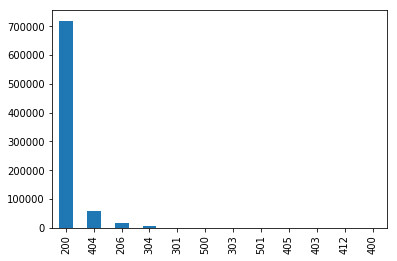

In [27]:
# Visualización del número de valores distintos que existen para la columnas categorica 'status'
%matplotlib inline

X_train['status'].value_counts().plot(kind='bar')

In [32]:
# Número de valores distintos que existen para la columna categorica 'ip'
X_train['ip'].value_counts().head(10)

198.50.156.189     134289
149.56.83.40        78176
205.167.170.15      26606
158.69.5.181        25590
134.249.53.185      14279
178.159.37.81       13156
192.227.172.158     10702
195.154.216.79       8888
158.64.79.7          8712
158.64.79.8          8486
Name: ip, dtype: int64

In [33]:
# Visualización del número de valores distintos que existen para la columnas categorica 'protocol_type'
X_train['request'].value_counts().head(10)

POST /administrator/index.php HTTP/1.1                            353981
GET /administrator/ HTTP/1.1                                       43738
GET /apache-log/access.log HTTP/1.0                                36779
GET /apache-log/access.log HTTP/1.1                                27004
GET / HTTP/1.1                                                     16478
GET /templates/_system/css/general.css HTTP/1.1                    15231
GET /administrator/index.php HTTP/1.1                              12417
GET http://almhuette-raith.at/administrator/index.php HTTP/1.1      9536
GET /robots.txt HTTP/1.1                                            7575
POST /administrator/index.php HTTP/1.0                              7366
Name: request, dtype: int64

In [35]:
# Visualización del número de valores distintos que existen para la columnas categorica 'protocol_type'
X_train['size'].value_counts().head(20)

4498     261508
4494      84819
4263      69140
239       16047
10479     15209
14032     13426
304        8252
4481       7282
4250       7075
217        6471
4267       5706
218        5621
11383      5149
4238       4766
88161      4017
62918      3862
10004      3860
4890       3786
74434      3778
33472      3765
Name: size, dtype: int64

In [36]:
# Visualización del número de valores distintos que existen para la columnas categorica 'protocol_type'
X_train['referer'].value_counts()

http://www.almhuette-raith.at/                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         74441
http://almhuette-raith.at/administrator/                                                                                                                                   

In [ ]:
# Visualización del número de valores distintos que existen para la columnas categorica 'protocol_type'
X_train['user_agent'].value_counts().plot(kind='bar')

In [ ]:
# Número de valores distintos que existen para la columna categorica 'service'
df2['service'].value_counts()

In [ ]:
# Número de valores distintos que existen para la columna categorica 'service'
%matplotlib inline

df2['service'].value_counts().plot(kind='bar', figsize=(20, 5))

In [ ]:
# Número de valores distintos que existen para la columna categorica 'flag'
df2['flag'].value_counts()

In [ ]:
# Visualización del número de valores distintos que existen para la columna categorica 'flag'
%matplotlib inline

df2['flag'].value_counts().plot(kind='bar')

In [ ]:
# Número de valores distintos que existen para la columna categorica 'class'
df2['Class'].value_counts()

In [ ]:
# Visualización del número de valores distintos que existen para la columna categorica 'flag'
%matplotlib inline

df2['Class'].value_counts().plot(kind='bar')

## 3. Correlaciones entre las características de entrada

Calcular las correlaciones entre las características de entrada y la característica de salida puede ayudarnos a diferenciar las características más importantes, así como, a añadir nuevas características.

* Se puede calcular el coeficiente de correlación estándar para ver la correlación entre cada par de atributos
* El coeficiente de correlación, solo mide **correlaciones lineales**, esto quiere decir que si x va hacia arriba, mediría si y va hacia arriba o hacia abajo.
* Hay que intentar buscar correlaciones sobre todo con el atributo objetivo o variable de salida (el que queremeos predecir)

In [ ]:
# Para esta parte, voy a copiar df2 en df2_corr para realizar los tests a partir de este nuevo DataFrame
df2_corr = df2.copy()
# Uso df2_corr para la codificacion de los valores en Attack = 1; Normal (no ataque) = 0; representados en la nueva columna "Class_coded"
df2_corr["Class_coded"] = (df2_corr["Class"] != 'normal').astype(int)

In [ ]:
df2_corr.head(15)

In [ ]:
corr_matrix = df2_corr.corr()

In [ ]:
corr_matrix["Class_coded"].sort_values(ascending=False)

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
corr = df2_corr.corr()
fig, ax = plt.subplots(figsize=(20, 20))
ax.matshow(corr)
plt.xticks(range(len(corr.columns)), corr.columns);
plt.yticks(range(len(corr.columns)), corr.columns);

In [ ]:
# Uso el Label encoder visto en clase, para asignar valores a las columnas de tipo object que tengo
# Esto lo haré en un nuevo DataFrame(4)

In [ ]:
from sklearn.preprocessing import LabelEncoder

def encode_features(df, list_features):
    label_encoder = LabelEncoder()
    for f in list_features:
        df[f] = label_encoder.fit_transform(df[f])
    return df

In [ ]:
df2_coded = encode_features(df2_corr, ["service", "protocol_type", "flag"])

In [ ]:
df2_coded.head()

In [ ]:
from pandas.plotting import scatter_matrix

attributes = ["Class_coded", "protocol_type", "service", "flag"]

scatter_matrix(df2_coded[attributes], figsize=(12,8))
plt.show()

In [ ]:
df2_coded.plot(kind='scatter', x='Class_coded', y='flag', alpha=0.1)
plt.show()

## 4. Preprocesamiento del conjunto de datos

###     4.1. Limpiando el conjunto de datos

La mayoria de los algoritmos de Machine Learning no pueden trabajar sobre caracteristicas que contengan valores nulos. Comprueba si el conjunto de datos contine valores nulos, de ser así, aplica alguna de las técnicas que se han visto a lo largo del curso para reemplazarlos:
* Eliminar las filas correspondientes
* Eliminar el atributo (columna) correspondiente
* Rellenarlos con un valor determinado (cero, media ...)

In [ ]:
df2.isna().any()

* No hay datos nulos en nuestro Dataframe

### 4.2. Transformación de los atributos categóricos

Los algoritmos de Machine Learning, por norma general, ingieren datos numéricos. Comprueba si existen valores categóricos en el conjunto de datos y aplica las transoformaciones necesarias para convertirlos a valores numéricos.  
**Justifica tu decisión**.

In [ ]:
# He usado get_dummies porque tuve problemas para implementar One Hot Encoder, aunque el resultado es el mismo
# Las columnas que he dividido a valores numericos eran aquellas formadas por valores categoricos, es decir, aquellas cuyo
# tipo era 'object': protocol_type, service, flag y Class
df2_coded = pd.get_dummies(df2, columns=['protocol_type', 'service', 'flag', 'Class'])
df2_coded.dtypes

* Ahora todas las columnas son de tipo numéricos

### 4.3. Escalado del conjunto de datos

Si los valores del conjunto de datos se encuentran en rangos muy diferentes, es posible que deban aplicarse técnicas de normalización o escalado para que el algoritmo de Machine Learning funcione mejor.  

Comprueba si los datos del conjunto de datos poseen valores muy dispares y, si se considera necesario, aplica una de las técnicas de escalado o normalización vista durante el curso. **Justifica tu decisión.**

In [ ]:
from sklearn.preprocessing import RobustScaler

# Para el conjunto de entrenamiento
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(df2_coded)

In [ ]:
from pandas import DataFrame

X_train_scaled = DataFrame(X_train_scaled)
X_train_scaled.head(15)

* El escalado ha producido un rodendeo de los valores, que ahora pasan a valor 0 o 1 (exactos). esto supone una gran pérdida de información, y por ello **no realizaré el escalado** de datos para este ejercicio concreto.

## 5. Selección y entrenamiento de los modelos

¡En este punto ya hemos realizado todas las transformaciones necesarias sobre los datos para que puedan ser ingeridos por un algoritmo de machine Learning!

Recuerda que debes seleccionar al menos dos algoritmos para completar el ejercicio:
* Un algoritmo de clasificación basado en aprendizaje supervisado (regresión logística, árbol de decisión, random forest)
* Un algoritmo de detección de anomalías (distribución gaussiana, isolation forest)

## 5.1. Algoritmo de clasificación elegido: Decision Tree Classifier

### 5.1.1. Carga de datos

In [ ]:
import pandas as pd

columns = ["duration","protocol_type","service","flag","src_bytes","dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins","logged_in","num_compromised","root_shell","su_attempted","num_root","num_file_creations","num_shells","num_access_files","num_outbound_cmds","is_host_login","is_guest_login","count","srv_count","serror_rate","srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate","diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count","dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate","dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate","dst_host_rerror_rate","dst_host_srv_rerror_rate", "Class", "temp"]

# Training data
X_train = pd.read_csv("NSL-KDD/KDDTrain+.txt", names=columns)
X_train = X_train.drop('temp', axis=1)

X_test = pd.read_csv("NSL-KDD/KDDTest+.txt", names=columns)
X_test = X_test.drop('temp', axis=1)

In [ ]:
# Divido los Datasets en entrada (X_train, X_test) y salida (Y_train, Y_test) mediante la separación de la columna "Class", 
# que considero el output buscado, puesto que indica si ha habido ataque o no

Y_train = pd.DataFrame({'Class' : []})
Y_train['Class'] = X_train['Class']
X_train = X_train.drop('Class', axis=1)

Y_test = pd.DataFrame({'Class' : []})
Y_test['Class'] = X_test['Class']
X_test = X_test.drop('Class', axis=1)

In [ ]:
from sklearn.model_selection import train_test_split

X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test, test_size=0.50)

In [ ]:
# Convierto Y_train e Y_test de Series a DataFrames
Y_train = pd.DataFrame(Y_train)
Y_test = pd.DataFrame(Y_test)

In [ ]:
# Llegados a este punto, voy a codificar los valores de la columna "Class" para los dataset de salida (Y's):
#    1 si es distinto de 'normal' y 0 si es igual
# (Lo podría haber hecho con el Label Encoder de antes, pero lo quise hacer de nuevo. El resultado es similar)

# NOTA: Cabe señalar que no podemos usar GET_DUMMIES o ONE_HOT-ENCODER, ya que el numero de columnas del dataset de 
# entrenamiento y el de test (o validación) puede ser diferente, y dará lugar a un error en la fase de predicción


Y_train["Class_coded"] = (Y_train["Class"].astype(str) != 'normal').astype(int)
Y_test["Class_coded"] = (Y_test["Class"].astype(str) != 'normal').astype(int)
Y_val["Class_coded"] = (Y_val["Class"].astype(str) != 'normal').astype(int)

In [ ]:
from sklearn.preprocessing import LabelEncoder

def encode_features(df, list_features):
    label_encoder = LabelEncoder()
    for f in list_features:
        df[f] = label_encoder.fit_transform(df[f])
    return df

In [ ]:
Y_train = Y_train.drop('Class', axis=1)
Y_test = Y_test.drop('Class', axis=1)
Y_val = Y_val.drop('Class', axis=1)

In [ ]:
# Codifico los conjuntos de entrada (X's) con el Label Encoder visto antes
X_train = encode_features(X_train, ["service", "protocol_type", "flag"])
X_test = encode_features(X_test, ["service", "protocol_type", "flag"])
X_val = encode_features(X_val, ["service", "protocol_type", "flag"])

In [ ]:
print ("X_train: Filas:", X_train.shape[0], ", columnas:", X_train.shape[1])
print ("Y_train: Filas:", Y_train.shape[0], ", columnas:", Y_train.shape[1])
print ("X_test: Filas:", X_test.shape[0], ", columnas:", X_test.shape[1])
print ("Y_test: Filas:", Y_test.shape[0], ", columnas:", Y_test.shape[1])
print ("X_val: Filas:", X_val.shape[0], ", columnas:", X_val.shape[1])
print ("Y_val: Filas:", Y_val.shape[0], ", columnas:", Y_val.shape[1])

In [ ]:
# Entrenamiento del modelo
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier()
clf.fit(X_train, Y_train)

In [ ]:
# Predicción de valores
Y_train_pred = clf.predict(X_train)
Y_test_pred = clf.predict(X_test)
Y_val_pred = clf.predict(X_val)

In [ ]:
from sklearn.metrics import confusion_matrix, recall_score, f1_score, precision_score

print("\nEntrenamiento Decision Tree Classifier")
print(confusion_matrix(Y_train, Y_train_pred))
print("\nTest Decision Tree Classifier")
print(confusion_matrix(Y_test, Y_test_pred))
print("\nValidación Decision Tree Classifier")
print(confusion_matrix(Y_val, Y_val_pred))

In [ ]:
f1_score_dectree_train = f1_score(Y_train_pred, Y_train, average="binary")
f1_score_dectree_test = f1_score(Y_test_pred, Y_test, average="binary")
f1_score_dectree_val = f1_score(Y_val_pred, Y_val, average="binary")

print("F1 Score for train set:", f1_score_dectree_train)
print("F1 Score for test set:", f1_score_dectree_test)
print("F1 Score for validation set:", f1_score_dectree_val)

## 5.2. Algoritmo de detección de anomalías elegido: distribución gaussiana

## 5.2.1. Carga de los datos

In [ ]:
import pandas as pd

columns = ["duration","protocol_type","service","flag","src_bytes","dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins","logged_in","num_compromised","root_shell","su_attempted","num_root","num_file_creations","num_shells","num_access_files","num_outbound_cmds","is_host_login","is_guest_login","count","srv_count","serror_rate","srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate","diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count","dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate","dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate","dst_host_rerror_rate","dst_host_srv_rerror_rate", "Class", "temp"]

# Training data
X_train = pd.read_csv("NSL-KDD/KDDTrain+.txt", names=columns)
X_train = X_train.drop('temp', axis=1)

# Test data
X_test = pd.read_csv("NSL-KDD/KDDTest+.txt", names=columns)
X_test = X_test.drop('temp', axis=1)

In [ ]:
# División del conjunto de entrenamiento en "Ataque" y "Normal" (= no ataque)
X_train_normal = X_train[X_train['Class'] == 'normal']
X_train_attack = X_train[X_train['Class'] != 'normal']

# División del conjunto de test en "Ataque" y "Normal" (= no ataque)
X_test_normal = X_test[X_test['Class'] == 'normal']
X_test_attack = X_test[X_test['Class'] != 'normal']

In [ ]:
# División del conjunto de entrenamiento "normal" (= no ataques) en Entrada (X) y salida (Y)
Y_train_normal = X_train_normal['Class']
X_train_normal = X_train_normal.drop('Class', axis=1)

# División del conjunto de entrenamiento "ataque" en Entrada (X) y salida (Y)
Y_train_attack = X_train_attack['Class']
X_train_attack = X_train_attack.drop('Class', axis=1)

# División del conjunto de test "normal" (= no ataques) en Entrada (X) y salida (Y)
Y_test_normal = X_test_normal['Class']
X_test_normal = X_test_normal.drop('Class', axis=1)

# División del conjunto de test "ataque" en Entrada (X) y salida (Y)
Y_test_attack = X_test_attack['Class']
X_test_attack = X_test_attack.drop('Class', axis=1)

In [ ]:
# Creación de los conjuntos de validación a partir de la división de los de test (50%-50%)
from sklearn.model_selection import train_test_split

X_test_normal, X_val_normal, Y_test_normal, Y_val_normal = train_test_split(X_test_normal, Y_test_normal, test_size=0.50)
X_test_attack, X_val_attack, Y_test_attack, Y_val_attack = train_test_split(X_test_attack, Y_test_attack, test_size=0.50)

### Mezclamos ejemplos legítimos y maliciosos en validación y pruebas

In [ ]:
import pandas as pd

# Conjunto de datos de entrenamiento
X_train = pd.concat([X_train_normal, X_train_attack], ignore_index=True)
Y_train = pd.concat([Y_train_normal, Y_train_attack], ignore_index=True)

# Conjunto de datos de pruebas
X_test = pd.concat([X_test_normal, X_test_attack], ignore_index=True)
Y_test = pd.concat([Y_test_normal, Y_test_attack], ignore_index=True)

# Conjunto de datos de validacion
X_val = pd.concat([X_val_normal, X_val_attack], ignore_index=True)
Y_val = pd.concat([Y_val_normal, Y_val_attack], ignore_index=True)

In [ ]:
# Método de codificación: Label Encoder

# Al igual que antes, no podemos usar GET_DUMMIES ni ONE_HOT-ENCODER porque el numero de columnas es diferente para el dataset
# de train y test (y validación)

from sklearn.preprocessing import LabelEncoder

def encode_features(df, list_features):
    label_encoder = LabelEncoder()
    for f in list_features:
        df[f] = label_encoder.fit_transform(df[f])
    return df

In [ ]:
# Codificación de todos los conjuntos de datos para los casos en lo que las columnas son de tipo Object
Y_train = pd.DataFrame(Y_train)
Y_test = pd.DataFrame(Y_test)
Y_val = pd.DataFrame(Y_val)

Y_train["Class_coded"] = (Y_train["Class"].astype(str) != 'normal').astype(int)
Y_test["Class_coded"] = (Y_test["Class"].astype(str) != 'normal').astype(int)
Y_val["Class_coded"] = (Y_val["Class"].astype(str) != 'normal').astype(int)

Y_train = Y_train.drop('Class', axis=1)
Y_test = Y_test.drop('Class', axis=1)
Y_val = Y_val.drop('Class', axis=1)

X_train = encode_features(X_train, ["service", "protocol_type", "flag"])
X_test = encode_features(X_test, ["service", "protocol_type", "flag"])
X_val = encode_features(X_val, ["service", "protocol_type", "flag"])

X_train_normal = encode_features(X_train_normal, ["service", "protocol_type", "flag"])
X_val_normal = encode_features(X_train_normal, ["service", "protocol_type", "flag"])
X_test_normal = encode_features(X_train_normal, ["service", "protocol_type", "flag"])

X_train_attack = encode_features(X_train_attack, ["service", "protocol_type", "flag"])
X_val_attack = encode_features(X_train_attack, ["service", "protocol_type", "flag"])
X_test_attack = encode_features(X_train_attack, ["service", "protocol_type", "flag"])

In [ ]:
print ("X_train: Filas:", X_train.shape[0], ", columnas:", X_train.shape[1])
print ("Y_train: Filas:", Y_train.shape[0], ", columnas:", Y_train.shape[1])
print ("X_test: Filas:", X_test.shape[0], ", columnas:", X_test.shape[1])
print ("Y_test: Filas:", Y_test.shape[0], ", columnas:", Y_test.shape[1])
print ("X_val: Filas:", X_val.shape[0], ", columnas:", X_val.shape[1])
print ("Y_val: Filas:", Y_val.shape[0], ", columnas:", Y_val.shape[1])
print ("X_train_normal: Filas:", X_train_normal.shape[0], ", columnas:", X_train_normal.shape[1])
print ("X_test_normal: Filas:", X_test_normal.shape[0], ", columnas:", X_test_normal.shape[1])
print ("X_val_normal: Filas:", X_val_normal.shape[0], ", columnas:", X_val_normal.shape[1])
print ("X_train_attack: Filas:", X_train_attack.shape[0], ", columnas:", X_train_attack.shape[1])
print ("X_test_attack: Filas:", X_test_attack.shape[0], ", columnas:", X_test_attack.shape[1])
print ("X_val_attack: Filas:", X_val_attack.shape[0], ", columnas:", X_val_attack.shape[1])

## Visualizando el conjunto de datos

In [ ]:
X_train_normal.info()

In [ ]:
X_train_normal.head(10)

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

df = pd.read_csv("NSL-KDD/KDDTrain+.txt", names=columns)
df = df.drop('temp', axis=1)

df = pd.get_dummies(df, columns=['protocol_type', 'service', 'flag'])

features = [f for f in list(df)
            if f not in ["Class", "protocol_type", "service", "flag"]]

plt.figure(figsize=(15,20*8))
gs = gridspec.GridSpec(61, 2)    #len(features) = 122
gs.update(hspace=0.8)

for i, f in enumerate(features):
    ax = plt.subplot(gs[i])
    sns.distplot(df[f][df["Class"] == 'normal'], color = "b")
    sns.distplot(df[f][df["Class"] != 'normal'], color = "r")
    ax.set_xlabel('')
    ax.set_title('feature: ' + str(f))

plt.show()

## 5.2.2. Implementando el algoritmo de distribución Gaussiana

In [ ]:
from scipy.stats import multivariate_normal
import numpy as np

class GaussianDistribution:
    def __init__(self):
        self._mu = None
        self._sigma = None
        
    def fit(self, X_train):
        self._mu, self._sigma = self._estimateGaussian(X_train)
        
    def predict(self, X_pred, threshold):
        pred = self.multivariateGaussian(X_pred)
        return (pred < threshold)

    def multivariateGaussian(self, dataset):
        pred = multivariate_normal(mean=self._mu, cov=self._sigma, allow_singular=True)
        return pred.pdf(dataset)
        
    def _estimateGaussian(self, dataset):
        mu = np.mean(dataset, axis=0)
        sigma = np.cov(dataset.T)
        return mu, sigma

In [ ]:
from sklearn.metrics import f1_score

def search_threshold(Y_val, preds_val):
    best_f1 = 0
    best_threshold = 0
    threshold = 1
    for i in range(900):
        threshold = threshold / 2
        print("\rSearching best threshold {0}%".format(
            int((i + 1) / 900 * 100)), end='')
        predictions = (preds_val < threshold)
        f1 = f1_score(Y_val, predictions, average='binary')
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
    return (best_f1, best_threshold)

## 5.2.3. Creación del modelo

In [ ]:
# Instanciamos el algoritmo de distribución gaussiana, y los entrenamos UNICAMENTE con los valores que no son ataques (='normal')
gauss = GaussianDistribution()

gauss.fit(X_train_normal)

**Realizo la predicción con el subconjunto de validación**

In [ ]:
val_preds = gauss.multivariateGaussian(X_val)

**Busco el mejor Threshold**

In [ ]:
best_f1, threshold = search_threshold(Y_val, val_preds)
print("\n\nBest threshold:", threshold, "- F1 Score:", best_f1)

**Verifico en Threshold con el conjunto de pruebas**

In [ ]:
test_preds = gauss.predict(X_test, threshold)

In [ ]:
# Matriz de confusión
from sklearn.metrics import confusion_matrix, recall_score, f1_score, precision_score

print("\nTest Distribución Gaussiana")
print(confusion_matrix(Y_test, test_preds))

In [ ]:
f1_score_gauss_test = f1_score(Y_test, test_preds, average = "binary")

print("F1 Score for test set:", f1_score_gauss_test)

## 5.2.4. Selección de características

#### Llegados a este punto, vamos a colver a evaluar el modelo, pero teniendo en cuenta únicamente las features (parámetros de nuestro dataset) en los que realmente se nota una diferencia entre los registros referidos a los ataques y a los normales (no-ataques)

#### Haremos la evaluación de la importancia de parámetros usando el algoritmo Random forest

In [ ]:
import pandas as pd

columns = ["duration","protocol_type","service","flag","src_bytes","dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins","logged_in","num_compromised","root_shell","su_attempted","num_root","num_file_creations","num_shells","num_access_files","num_outbound_cmds","is_host_login","is_guest_login","count","srv_count","serror_rate","srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate","diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count","dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate","dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate","dst_host_rerror_rate","dst_host_srv_rerror_rate", "Class", "temp"]

# Training data
X_train_fs = pd.read_csv("NSL-KDD/KDDTrain+.txt", names=columns)
X_train_fs = X_train_fs.drop('temp', axis=1)

Y_train_fs = pd.DataFrame({'Class' : []})
Y_train_fs['Class'] = X_train_fs['Class']
X_train_fs = X_train_fs.drop('Class', axis=1)

# Test data
X_test_fs = pd.read_csv("NSL-KDD/KDDTest+.txt", names=columns)
X_test_fs = X_test_fs.drop('temp', axis=1)

Y_test_fs = pd.DataFrame({'Class' : []})
Y_test_fs['Class'] = X_test_fs['Class']
X_test_fs = X_test_fs.drop('Class', axis=1)

In [ ]:
from sklearn.preprocessing import LabelEncoder

def encode_features(df, list_features):
    label_encoder = LabelEncoder()
    for f in list_features:
        df[f] = label_encoder.fit_transform(df[f])
    return df

In [ ]:
# Codificación de todos los conjuntos de datos para los cosas en lo qe las columnas son de tipo Object
X_train_fs = encode_features(X_train_fs, ["service", "protocol_type", "flag"])
X_test_fs = encode_features(X_test_fs, ["service", "protocol_type", "flag"])

Y_train_fs = pd.DataFrame(Y_train_fs)
Y_test_fs = pd.DataFrame(Y_test_fs)

Y_train_fs["Class_coded"] = (Y_train_fs["Class"].astype(str) != 'normal').astype(int)
Y_test_fs["Class_coded"] = (Y_test_fs["Class"].astype(str) != 'normal').astype(int)

Y_train_fs = Y_train_fs.drop('Class', axis=1)
Y_test_fs = Y_test_fs.drop('Class', axis=1)

#### Entrenamos el algoritmo Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
rnd_clf.fit(X_train_fs, Y_train_fs)

In [ ]:
# Conjunto de los valores de entrada
X_fs = pd.concat([X_train_fs, X_test_fs], ignore_index=True)

In [ ]:
for name, score in zip(list(X_fs), rnd_clf.feature_importances_):
    print(name, score)

In [ ]:
for name, score in zip(list(X_fs), rnd_clf.feature_importances_):
    if score > 0.02:
        print("\"" + name + "\"", end=",")

## 5.2.5. Reevaluación del modelo

#### Vamos a volver a evaluar nuestro modelo de Machine Learning de Distribución Gaussiana, pero ahora con las características más inlfuyentes, vistas en el apartado anterior

## 5.2.1. Carga de los datos

In [ ]:
import pandas as pd

columns = ["protocol_type","service","flag","src_bytes","dst_bytes","logged_in","count","srv_serror_rate","same_srv_rate","diff_srv_rate","dst_host_srv_count","dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate", "Class", "temp"]

# Training data
X_train = pd.read_csv("NSL-KDD/KDDTrain+.txt", names=columns)
X_train = X_train.drop('temp', axis=1)

# Test data
X_test = pd.read_csv("NSL-KDD/KDDTest+.txt", names=columns)
X_test = X_test.drop('temp', axis=1)

In [ ]:
X_train_normal = X_train[X_train['Class'] == 'normal']
X_train_attack = X_train[X_train['Class'] != 'normal']

X_test_normal = X_test[X_test['Class'] == 'normal']
X_test_attack = X_test[X_test['Class'] != 'normal']

In [ ]:
# Ejemplos normales - train
Y_train_normal = X_train_normal['Class']
X_train_normal = X_train_normal.drop('Class', axis=1)

# Ejemplos ataques - train
Y_train_attack = X_train_attack['Class']
X_train_attack = X_train_attack.drop('Class', axis=1)

# Ejemplos normales - test
Y_test_normal = X_test_normal['Class']
X_test_normal = X_test_normal.drop('Class', axis=1)

# Ejemplos ataques - test
Y_test_attack = X_test_attack['Class']
X_test_attack = X_test_attack.drop('Class', axis=1)

In [ ]:
# División del conjunto de test en test y validacion
from sklearn.model_selection import train_test_split

X_test_normal, X_val_normal, Y_test_normal, Y_val_normal = train_test_split(X_test_normal, Y_test_normal, test_size=0.50)
X_test_attack, X_val_attack, Y_test_attack, Y_val_attack = train_test_split(X_test_attack, Y_test_attack, test_size=0.50)

### Mezclamos ejemplos legítimos y maliciosos en validación y pruebas

In [ ]:
import pandas as pd

# Conjunto de datos de pruebas
X_train = pd.concat([X_train_normal, X_train_attack], ignore_index=True)
Y_train = pd.concat([Y_train_normal, Y_train_attack], ignore_index=True)

# Conjunto de datos de pruebas
X_test = pd.concat([X_test_normal, X_test_attack], ignore_index=True)
Y_test = pd.concat([Y_test_normal, Y_test_attack], ignore_index=True)

# Conjunto de datos de validacion
X_val = pd.concat([X_val_normal, X_val_attack], ignore_index=True)
Y_val = pd.concat([Y_val_normal, Y_val_attack], ignore_index=True)

In [ ]:
# Como antes, codificamos con LabelEncoder

from sklearn.preprocessing import LabelEncoder

def encode_features(df, list_features):
    label_encoder = LabelEncoder()
    for f in list_features:
        df[f] = label_encoder.fit_transform(df[f])
    return df

In [ ]:
# Codificación de todos los conjuntos de datos para los cosas en lo qe las columnas son de tipo Object
X_train = encode_features(X_train, ["protocol_type", "flag"])
X_test = encode_features(X_test, ["protocol_type", "flag"])
X_val = encode_features(X_val, ["protocol_type", "flag"])

Y_train = pd.DataFrame(Y_train)
Y_test = pd.DataFrame(Y_test)
Y_val = pd.DataFrame(Y_val)

Y_train["Class_coded"] = (Y_train["Class"].astype(str) != 'normal').astype(int)
Y_test["Class_coded"] = (Y_test["Class"].astype(str) != 'normal').astype(int)
Y_val["Class_coded"] = (Y_val["Class"].astype(str) != 'normal').astype(int)

Y_train = Y_train.drop('Class', axis=1)
Y_test = Y_test.drop('Class', axis=1)
Y_val = Y_val.drop('Class', axis=1)

X_train_normal = encode_features(X_train_normal, ["protocol_type", "flag"])
X_val_normal = encode_features(X_train_normal, ["protocol_type", "flag"])
X_test_normal = encode_features(X_train_normal, ["protocol_type", "flag"])

X_train_attack = encode_features(X_train_attack, ["protocol_type", "flag"])
X_val_attack = encode_features(X_train_attack, ["protocol_type", "flag"])
X_test_attack = encode_features(X_train_attack, ["protocol_type", "flag"])

In [ ]:
print ("X_train: Filas:", X_train.shape[0], ", columnas:", X_train.shape[1])
print ("Y_train: Filas:", Y_train.shape[0], ", columnas:", Y_train.shape[1])
print ("X_test: Filas:", X_test.shape[0], ", columnas:", X_test.shape[1])
print ("Y_test: Filas:", Y_test.shape[0], ", columnas:", Y_test.shape[1])
print ("X_val: Filas:", X_val.shape[0], ", columnas:", X_val.shape[1])
print ("Y_val: Filas:", Y_val.shape[0], ", columnas:", Y_val.shape[1])
print ("X_train_normal: Filas:", X_train_normal.shape[0], ", columnas:", X_train_normal.shape[1])
print ("X_test_normal: Filas:", X_test_normal.shape[0], ", columnas:", X_test_normal.shape[1])
print ("X_val_normal: Filas:", X_val_normal.shape[0], ", columnas:", X_val_normal.shape[1])
print ("X_train_attack: Filas:", X_train_attack.shape[0], ", columnas:", X_train_attack.shape[1])
print ("X_test_attack: Filas:", X_test_attack.shape[0], ", columnas:", X_test_attack.shape[1])
print ("X_val_attack: Filas:", X_val_attack.shape[0], ", columnas:", X_val_attack.shape[1])

## Visualizando el conjunto de datos

In [ ]:
X_train_normal.info()

In [ ]:
X_train_normal.head(10)

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

columns = ["flag","src_bytes","dst_bytes","same_srv_rate","diff_srv_rate","dst_host_srv_count","dst_host_same_srv_rate","dst_host_diff_srv_rate", "Class", "temp"]
    
df = pd.read_csv("NSL-KDD/KDDTrain+.txt", names=columns)
df = df.drop('temp', axis=1)

df = encode_features(df, ["flag"])

features = [f for f in list(df)
            if f not in ["Class"]]

plt.figure(figsize=(15,20*8))
gs = gridspec.GridSpec(61, 2)
gs.update(hspace=0.8)

for i, f in enumerate(features):
    ax = plt.subplot(gs[i])
    sns.distplot(df[f][df["Class"] == 'normal'], color = "b")
    sns.distplot(df[f][df["Class"] != 'normal'], color = "r")
    ax.set_xlabel('')
    ax.set_title('feature: ' + str(f))

plt.show()

## 5.2.2. Implementando el algoritmo de distribución Gaussiana

In [ ]:
from scipy.stats import multivariate_normal
import numpy as np

class GaussianDistribution:
    def __init__(self):
        self._mu = None
        self._sigma = None
        
    def fit(self, X_train):
        self._mu, self._sigma = self._estimateGaussian(X_train)
        
    def predict(self, X_pred, threshold):
        pred = self.multivariateGaussian(X_pred)
        return (pred < threshold)

    def multivariateGaussian(self, dataset):
        pred = multivariate_normal(mean=self._mu, cov=self._sigma, allow_singular=True)
        return pred.pdf(dataset)
        
    def _estimateGaussian(self, dataset):
        mu = np.mean(dataset, axis=0)
        sigma = np.cov(dataset.T)
        return mu, sigma

In [ ]:
from sklearn.metrics import f1_score

def search_threshold(Y_val, preds_val):
    best_f1 = 0
    best_threshold = 0
    threshold = 1
    for i in range(900):
        threshold = threshold / 2
        print("\rSearching best threshold {0}%".format(
            int((i + 1) / 900 * 100)), end='')
        predictions = (preds_val < threshold)
        f1 = f1_score(Y_val, predictions, average='binary')
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
    return (best_f1, best_threshold)

## 5.2.3. Creación del modelo

In [ ]:
# Instanciacimos el algoritmo de distribución gaussiana
gauss = GaussianDistribution()

gauss.fit(X_train_normal)

**Predicción para el conjunto de validación**

In [ ]:
val_preds = gauss.multivariateGaussian(X_val)

**Busco el mejor Threshold**

In [ ]:
best_f1, threshold = search_threshold(Y_val, val_preds)
print("\n\nBest threshold:", threshold, "- F1 Score:", best_f1)

**Verifico en Threshold con el conjunto de pruebas**

In [ ]:
test_preds = gauss.predict(X_test, threshold)

In [ ]:
# Matriz de confusión
from sklearn.metrics import confusion_matrix, recall_score, f1_score, precision_score

print("\nTest Distribución Gaussiana")
print(confusion_matrix(Y_test, test_preds))

In [ ]:
f1_score_gauss_test = f1_score(Y_test, test_preds, average = "binary")

print("F1 Score for test set:", f1_score_gauss_test)

## 6. Métricas y comparación de los resultados

Selecciona un conjunto de métricas que permitan evaluar de manera adecuada el resultado de los modelos que has entrenado previamente. **Justifica tu decisión**  

Compara los resultados obtenidos con ambos modelos y **justifica la razón por la que consideras que un modelo se comporta mejor que el otro.**

Fijándonos en el F1-Score (aunque también podríamos hacerlo con las Matrices de Confusión que hemos obtenido), los resultados  han sido:

1) **Decision Tree Classifier**
   - F1_score for test set: _0.7609065155807365_

2) **Distribución Gaussiana**
   - F1 Score for test set: _0.7798355490663184_
   

3) **Distribución Gaussiana +** Elección de características mediante **Random Forest**
   - F1 Score for test set: _0.8511604439959637_

* Aunque los valores cambian ligeramente cada vez que entrenamos los algoritmos, no suponen una gran diferencia, y por tanto podemos concluir que los mejores resultados se obtienen en el tercer caso (**Distr. Gaussiana + Random Forest**), en el que la aplicación de Random Forest para la elección de los paramétros del dataset puede mejorar en torno al _7,5-9%_ la clasificación correcta de las muestras respecto a Decision Tree Classifier y a la Gaussiana sin elección de características.